# FuseTS - MOGPR S1 S2 / Phenology openEO Workflow

In this notebook, we'll demonstrate how to use openEO's diverse capabilities to build a workflow for fusing data and executing time series analysis. In this particular case, we'll integrate both FuseTS's MOGPR service and the Phenology service into a single workflow to compute phenology metrics for a specific field. The end product of this process will be a NetCDF file containing the final phenology metrics.

**Prerequisites**
- In this notebook, we utilize openEO to retrieve time series data. To leverage the full range of openEO features, you can create a free trial account on the [openEO Platform](https://docs.openeo.cloud/join/free_trial.html) and receive 1000 free credits, enabling you to execute the functionalities showcased in this notebook.


Lets start with importing the different libraries that we need within this notebook.


## Setting up the environment

First of all we need to make sure that all our dependencies are correctly installed.


In [1]:
!pip install openeo

In [2]:

import json
import warnings

import numpy as np
import openeo
from openeo.metadata import CollectionMetadata, BandDimension, Band
from ipyleaflet import GeoJSON, Map, basemaps

warnings.filterwarnings("ignore")

# Exploring the area of interest
In this first part, we will explore the area of interest that will be used for calculating the phenology metrics.

In [3]:
year = 2023

spat_ext = {
        "type": "Polygon",
        "coordinates": [
            [
                [5.170012098271149, 51.25062964728295],
                [5.17085904378298, 51.24882567194015],
                [5.17857421368097, 51.2468515482926],
                [5.178972704726344, 51.24982704376254],
                [5.170012098271149, 51.25062964728295],
            ]
        ],
    }
temp_ext = [f"{year}-01-01", f"{year}-12-30"]

Plot the area to see what we're working with.


In [4]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 16

m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m

Map(center=[51.249352711712234, 5.173686031746518], controls=(ZoomControl(options=['position', 'zoom_in_text',…

# Setting up connection with openEO

The first step in setting up the workflow, is creating a connection with openEO. 

In [5]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


# Creating the fused data set using MOGPR

In the following section, we will leverage the capabilities of openEO to generate a fused dataset using MOGPR.

In [6]:
service = 'mogpr_s1_s2'
namespace = 'u:fusets'
mogpr = connection.datacube_from_process(service,
                                         namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}',
                                         polygon=spat_ext, date=temp_ext, s1_collection='RVI ASC', s2_collection='NDVI')

mogpr.metadata = CollectionMetadata(metadata={},dimensions=[BandDimension(name='bands',bands=[Band('RVI ASC'),Band('NDVI')])])

# Adding phenology service

After setting up the base, fused datacube through MOGPR, we can extend the workflow with the phenology calculation.

In [7]:
mogpr_ndvi = mogpr.band('NDVI')

In [8]:
service = 'phenology'
namespace = 'u:fusets'
phenology = connection.datacube_from_process(service,
                                             namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}',
                                             data=mogpr_ndvi)

# Downloading the results
Now that we've setup our workflow, we can now download the results by starting an openEO batch job.

In [9]:
phenology_output_file = './phenology.nc'
phenology_job = phenology.execute_batch(phenology_output_file, out_format="netcdf",
                                        title=f'FuseTS - MOGPR - Phenology', job_options={
        'executor-memory': '8g',
        'udf-dependency-archives': [
            'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets_venv.zip#tmp/venv',
            'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets.zip#tmp/venv_static'
        ]
    })

0:00:00 Job 'j-2403269b1f4f43fb848fc8594891598b': send 'start'
0:01:05 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:01:10 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:01:17 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:01:30 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:01:40 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:01:52 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:02:08 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:02:27 Job 'j-2403269b1f4f43fb848fc8594891598b': queued (progress N/A)
0:02:51 Job 'j-2403269b1f4f43fb848fc8594891598b': running (progress N/A)
0:03:21 Job 'j-2403269b1f4f43fb848fc8594891598b': running (progress N/A)
0:03:59 Job 'j-2403269b1f4f43fb848fc8594891598b': running (progress N/A)
0:04:46 Job 'j-2403269b1f4f43fb848fc8594891598b': running (progress N/A)
0:05:44 Job 'j-2403269b1f4f43fb848fc8594891598b': running (progress N

# Explore the results¶

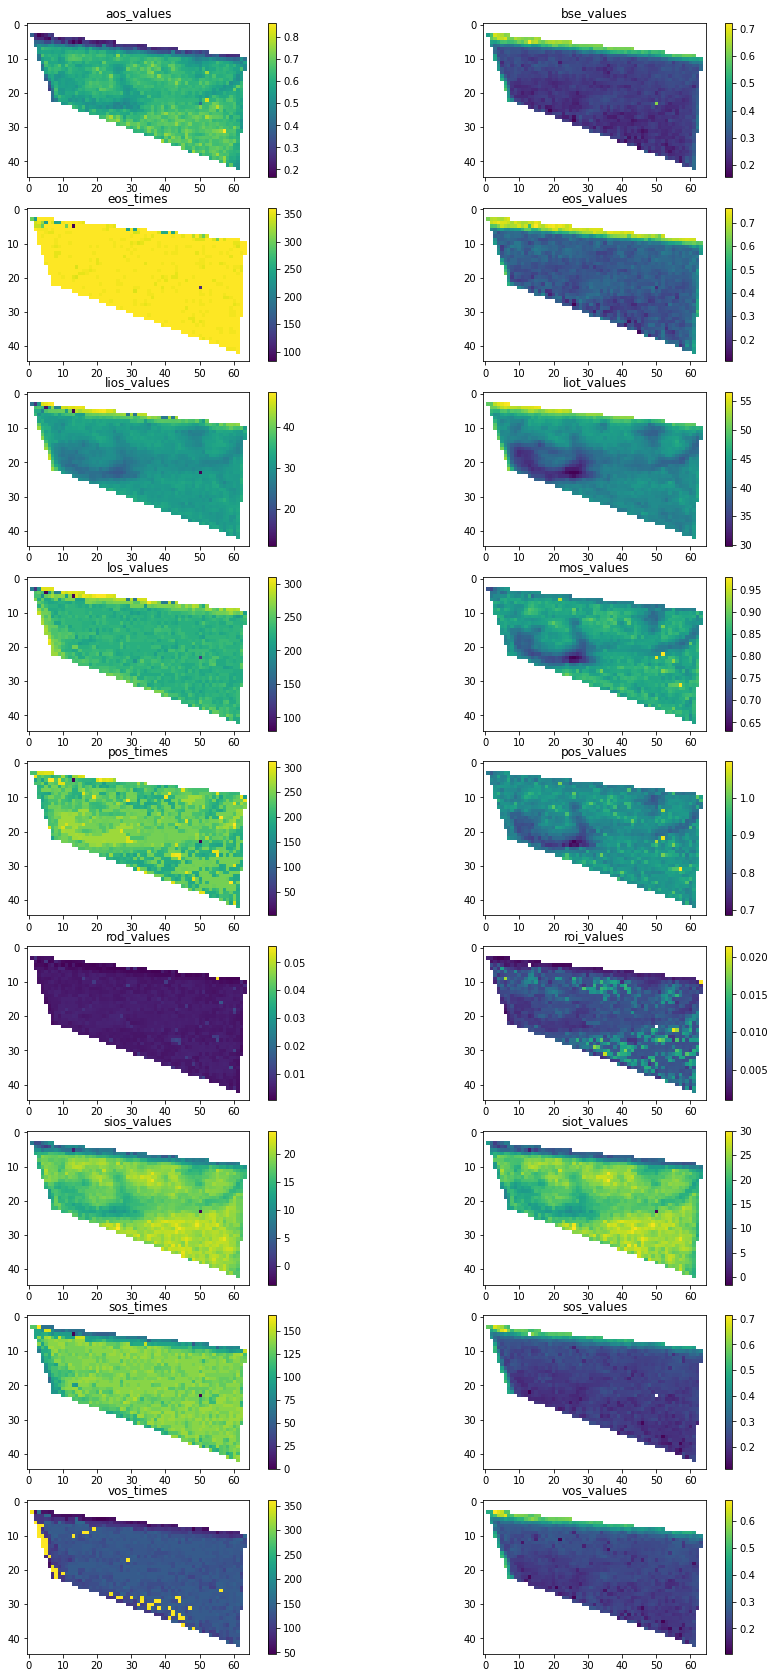

In [10]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import math

nc_file = nc.Dataset(phenology_output_file)
keys = [x for x in nc_file.variables.keys() if x not in ['phenology', 'x', 'y', 'crs']]
keys.sort()

lat = nc_file.variables['x'][:]
lon = nc_file.variables['y'][:]

ncols = 2
nrows = math.ceil(len(keys) / ncols)
col = 0
row = 0

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30))

for i, key in enumerate(keys):

    variable = nc_file.variables[key][0]
    im_pred = axs[row, col].imshow(variable)
    axs[row, col].set_title(key)
    fig.colorbar(im_pred, ax=axs[row, col])

    col = (col + 1) % ncols
    if col == 0:
        row += 1
plt.show()